In [4]:
import torch as T
import torch.nn as nn
import torch.optim as optim
import torchvision.utils as utils
import torchvision.datasets as Datasets
import torchvision.transforms as transforms
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm

device = T.device('cuda' if T.cuda.is_available() else 'cpu')
print('Device : ', device)

Device :  cuda


In [5]:
class Generator(nn.Module):
    def __init__(self, d_noise, d_hidden, device, alpha=0.0002):
        super(Generator, self).__init__()
        self.G = nn.Sequential(
                                nn.Linear(d_noise, d_hidden),
                                nn.ELU(),
                                nn.Dropout(0.1),
                                nn.Linear(d_hidden, d_hidden),
                                nn.ELU(),
                                nn.Dropout(0.1),
                                nn.Linear(d_hidden, 28*28),
                                nn.Tanh()
                                ).apply(initialize_weight)

        self.optimizer = optim.AdamW(self.parameters(), lr = alpha)
        self.to(device)

    def forward(self, input):
        out = self.G(input)
        return out

class Discriminator(nn.Module):
    def __init__(self, data_size, d_hidden, device, bata=0.0002):
        super(Discriminator, self).__init__()
        self.D = nn.Sequential(
                                nn.Linear(data_size, d_hidden),
                                nn.LeakyReLU(),
                                nn.Dropout(0.1),
                                nn.Linear(d_hidden, d_hidden),
                                nn.LeakyReLU(),
                                nn.Dropout(0.1),
                                nn.Linear(d_hidden, 1),
                                nn.Sigmoid()
                                ).apply(initialize_weight)
    
        self.optimizer = optim.AdamW(self.parameters(), lr = bata)
        self.to(device)

    def forward(self, input):
        out = self.D(input)
        return out

def initialize_weight(m, std=1.0, bias_const=1e-6):
    if isinstance(m, nn.Linear):
        nn.init.orthogonal_(m.weight, std)
        nn.init.constant_(m.bias, bias_const)
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        nn.init.xavier_uniform_(m.weight, gain=1.0)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)

In [6]:
d_noise  = 100       # latent variable
d_hidden = 256
batch_size = 200
image_size = 28*28

# standardization code
standardizator = transforms.Compose([
                    transforms.ToTensor(),
                    transforms.Normalize(
                        mean=(0.5),
                        std=(0.5)
                        ),
                    ])

# MNIST dataset
train_data = Datasets.MNIST(root='data/', train=True, transform=standardizator, download=True)
test_data  = Datasets.MNIST(root='data/', train=False, transform=standardizator, download=False)

train_data_loader = T.utils.data.DataLoader(train_data, batch_size, shuffle=True, num_workers=8, pin_memory=True)
test_data_loader  = T.utils.data.DataLoader(test_data, batch_size, shuffle=True, num_workers=8, pin_memory=True)

G = Generator(d_noise, d_hidden, device)
D = Discriminator(image_size, d_hidden, device)

criterion = nn.BCELoss()

0it [00:00, ?it/s]Downloading http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz to data/MNIST\raw\train-images-idx3-ubyte.gz
9920512it [04:53, 31704.69it/s]                             Extracting data/MNIST\raw\train-images-idx3-ubyte.gz to data/MNIST\raw

0it [00:00, ?it/s]Downloading http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz to data/MNIST\raw\train-labels-idx1-ubyte.gz

 57%|█████▋    | 16384/28881 [00:00<00:00, 97163.51it/s]

0it [00:00, ?it/s]Extracting data/MNIST\raw\train-labels-idx1-ubyte.gz to data/MNIST\raw


  0%|          | 0/1648877 [00:00<?, ?it/s]

  1%|          | 16384/1648877 [00:00<00:25, 64865.06it/s]

  1%|▏         | 24576/1648877 [00:00<00:35, 45716.79it/s]

  2%|▏         | 32768/1648877 [00:01<00:41, 39409.94it/s]

  2%|▏         | 40960/1648877 [00:01<00:43, 36894.79it/s]

  3%|▎         | 49152/1648877 [00:01<00:45, 35283.44it/s]

  3%|▎         | 57344/1648877 [00:01<00:46, 33898.44it/s]

  4%|▍         | 65536/1648877 [00:02<00:47

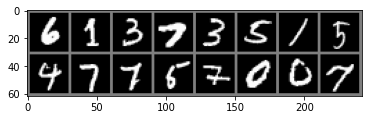

In [8]:
def imshow(img):
    img = (img+1)/2    
    img = img.squeeze()
    np_img = img.numpy()
    plt.imshow(np_img, cmap='gray')
    plt.show()

def imshow_grid(img): 
    img = utils.make_grid(img.cpu().detach())
    img = (img+1)/2
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show()

example_mini_batch_img, example_mini_batch_label  = next(iter(train_data_loader))
imshow_grid(example_mini_batch_img[0:16,:,:])

z :  tensor([[-1.6024, -1.2228, -1.9916, -0.2129,  1.7934,  0.6131,  0.0544, -0.1287,
         -1.3907, -0.0283,  0.1991,  1.6026,  0.2428, -0.7488, -0.9356, -0.8580,
         -0.3715, -1.2126, -0.3862, -1.6142, -0.4703, -0.1757, -0.2447, -0.1222,
          0.3147, -1.2113, -0.5180,  1.6968,  1.9681,  0.4861,  1.3629,  1.0049,
          0.7374,  0.1100,  0.2733,  0.3947, -1.3281,  1.9536, -0.9216,  2.3309,
          2.0218, -0.4997, -0.6464, -0.4489,  0.0623, -0.4968, -0.0678,  1.7123,
          0.0847, -0.0369, -0.4609,  1.6935,  1.2811, -0.5699,  0.8500, -0.3201,
          0.3476,  0.0037,  0.6709,  0.1435,  0.1356, -0.8468,  1.5609, -1.0053,
         -0.1406,  0.6061, -0.8617, -0.7789,  0.7082,  1.2574, -0.4859,  0.1984,
         -0.5522, -0.9849,  0.8211, -0.6641, -1.7706, -2.5384,  0.6870,  0.4359,
         -0.3544, -0.1924,  1.8297,  0.7645, -0.9816, -0.7993, -0.2538,  0.8339,
         -0.1044, -1.2356,  0.4903,  0.5986, -1.2845, -1.3391,  0.2297,  1.7109,
         -1.4025,  0.99

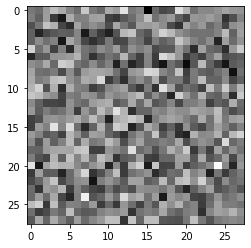

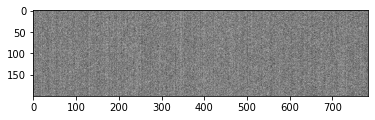

In [9]:
# noise
def sample_z(batch_size = 1, d_noise=100):
    return T.randn(batch_size, d_noise, device=device)

z = sample_z()
print('z : ',z, '\nz shape : ',z.shape) 
img_fake = G(z).view(-1,28,28)
imshow(img_fake.squeeze().cpu().detach())

z = sample_z(batch_size)
img_fake = G(z)
imshow_grid(img_fake)


In [10]:
def run_epoch(generator, discriminator, _optimizer_g, _optimizer_d):
    for img_batch, label_batch in train_data_loader:
        
        img_batch, label_batch = img_batch.to(device), label_batch.to(device) 
        # print(img_batch.view(-1, 28*28).shape)
        p_real = discriminator(img_batch.view(-1, 28*28)) # batch, 28 * 28 -> batch, 1
        # print('p_real',p_real.shape)
        p_fake = discriminator(generator(sample_z(batch_size, d_noise))) # batch, 100 -> batch, 1
        # print('p_fake',p_fake.shape)
        loss_real = -1 * T.log(p_real)
        # print('loss_real',loss_real.shape)
        loss_fake = -1 * T.log(1.-p_fake)
        # print('loss_fake',loss_fake.shape)
        loss_d = (loss_real + loss_fake).mean()
        # print('loss_d',loss_d)

        _optimizer_d.zero_grad()
        loss_d.backward()
        _optimizer_d.step()

        p_fake = discriminator(generator(sample_z(batch_size, d_noise)))
        loss_g = -1 * T.log(p_fake).mean() 
       
        _optimizer_g.zero_grad()
        loss_g.backward()
        _optimizer_g.step()

        # based on Cross Entropy
        # loss_d = criterion(p_real, T.ones_like(p_real).to(device)) + criterion(p_fake, T.zeros_like(p_real).to(device)) 

        # loss_g = criterion(p_fake, T.ones_like(p_fake).to(device)) #


In [11]:
def evaluate_model(generator, discriminator):
    p_real, p_fake = 0.,0.
    generator.eval()
    discriminator.eval()
    for img_batch, label_batch in test_data_loader:
        
        img_batch, label_batch = img_batch.to(device), label_batch.to(device) 
        
        with T.no_grad():
            p_real += (T.sum(discriminator(img_batch.view(-1, 28*28))).item())/10000.
            p_fake += (T.sum(discriminator(generator(sample_z(batch_size, d_noise)))).item())/10000.
        
    return p_real, p_fake

 24%|██▍       | 49/200 [03:34<10:59,  4.37s/it](epoch 50/200) p_real: 0.707171, p_g: 0.371129


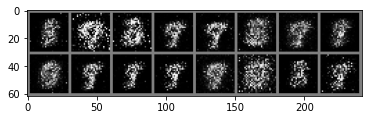

 50%|████▉     | 99/200 [07:12<07:20,  4.36s/it](epoch 100/200) p_real: 0.772194, p_g: 0.307676


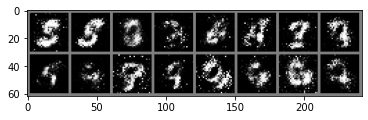

 74%|███████▍  | 149/200 [10:50<03:45,  4.42s/it](epoch 150/200) p_real: 0.766210, p_g: 0.328009


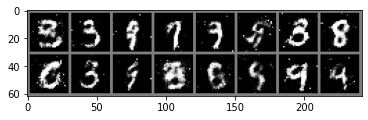

100%|█████████▉| 199/200 [14:30<00:04,  4.36s/it](epoch 200/200) p_real: 0.726964, p_g: 0.177147


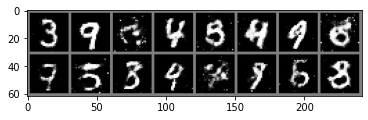

100%|██████████| 200/200 [14:34<00:00,  4.37s/it]


In [12]:
p_real_trace = []
p_fake_trace = []

for epoch in tqdm(range(200)):
    
    run_epoch(G, D, G.optimizer, D.optimizer)
    p_real, p_fake = evaluate_model(G, D)
    
    p_real_trace.append(p_real)
    p_fake_trace.append(p_fake) 
    
    if((epoch+1)% 50 == 0):
        print('(epoch %i/200) p_real: %f, p_g: %f' % (epoch+1, p_real, p_fake))
        imshow_grid(G(sample_z(16)).view(-1, 1, 28, 28))

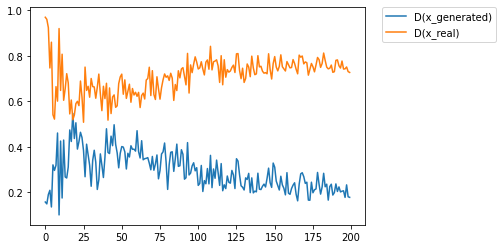

In [13]:
plt.plot(p_fake_trace, label='D(x_generated)')
plt.plot(p_real_trace, label='D(x_real)')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()

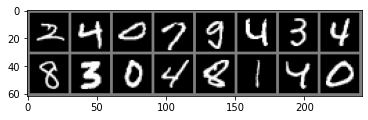

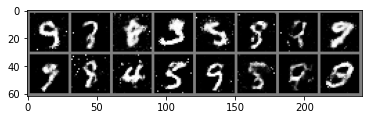

In [14]:
vis_loader = T.utils.data.DataLoader(test_data, 16, True)
img_vis, label_vis   = next(iter(vis_loader))
imshow_grid(img_vis)

imshow_grid(G(sample_z(16,100)).view(-1, 1, 28, 28))